In [1]:
import os

import pandas as pd
import scipy as sp
import scanpy as sc
sc.set_figure_params(dpi=120)

DATA_PATH = os.path.expanduser("./")

//anaconda3/envs/scanpy/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Load data

In [2]:
!ls $DATA_PATH

count_matrix.mtx             graph_distances.mtx      raw_count_matrix.mtx
embedding.csv                metadata.csv             scanpy_integration.R
genes.csv                    pca.csv                  scanpy_integration.ipynb
graph_connectivities.mtx pseudopca.csv


In [3]:
gene_df = pd.read_csv(DATA_PATH + "genes.csv")

metadata = pd.read_csv(DATA_PATH + "metadata.csv")
metadata.index = metadata.CellId
del metadata["CellId"]

embedding_df = pd.read_csv(DATA_PATH + "embedding.csv")
# Decide between using PCA or pseudo-PCA
pseudopca_df = pd.read_csv(DATA_PATH + "pseudopca.csv")
#pca_df = pd.read_csv(DATA_PATH + "pca.csv")

graph_conn_mtx = sp.io.mmread(DATA_PATH + "graph_connectivities.mtx")
graph_dist_mtx = sp.io.mmread(DATA_PATH + "graph_distances.mtx")

### Create ScanPy object 

In [4]:
# Begin by reading in raw counts
adata = sc.read_mtx(DATA_PATH + "raw_count_matrix.mtx")
adata

AnnData object with n_obs × n_vars = 12000 × 33694 

In [5]:
adata.var_names = gene_df["gene"].values
adata.obs_names = metadata.index.values

adata.obs = metadata.copy()

# Depends on which PCA you loaded
adata.X_pca = pseudopca_df.values
adata.obsm['X_pca'] = pseudopca_df.values

# Name according to embedding you saved
adata.X_umap = embedding_df.values
adata.obsm['X_umap'] = embedding_df.values

adata.uns['neighbors'] = dict(connectivities=graph_conn_mtx.tocsr(), distances=graph_dist_mtx.tocsr())
adata.uns['neighbors']['params'] = dict(n_pcs=pca_df.shape[1], use_rep='X_pca', metric='cosine', method='umap', n_neighbors=30)
# Assign raw counts to .raw slot, load in normalised counts
adata.raw = adata
adata_temp = sc.read_mtx(DATA_PATH + "count_matrix.mtx")
adata.X = adata_temp.X

# Change into categorical variable (helps with plotting)
adata.obs['Cluster'] = adata.obs['Cluster'].astype('category')
adata.obs['Dataset'] = adata.obs['Dataset'].astype('category')

## Analysis

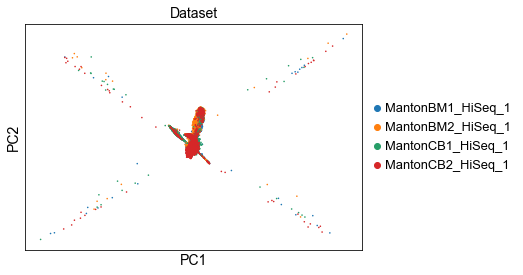

In [6]:
sc.pl.pca(adata, color='Dataset', frameon=True)

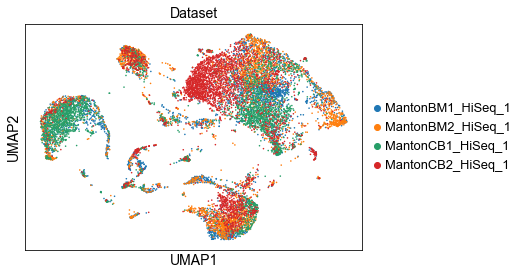

In [7]:
sc.pl.umap(adata, color='Dataset', frameon=True)

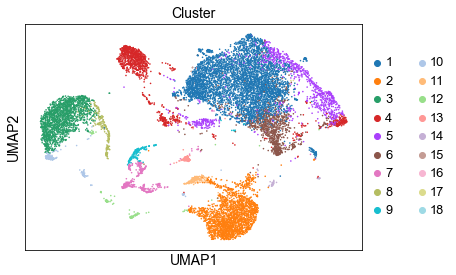

In [8]:
sc.pl.umap(adata, color='Cluster', frameon=True)

//anaconda3/envs/scanpy/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


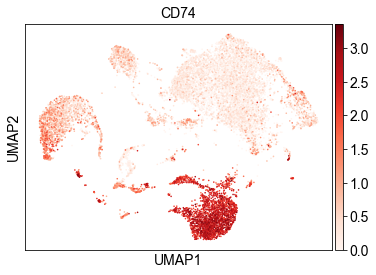

In [9]:
sc.pl.umap(adata, color='CD74', frameon=True, cmap='Reds', use_raw=False)

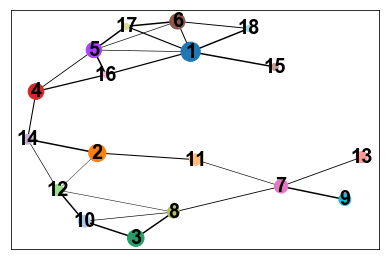

In [10]:
sc.tl.paga(adata, groups='Cluster')
sc.pl.paga(adata, color='Cluster', threshold=0.2, fontsize=20, node_size_scale=1, edge_width_scale=0.2, node_size_power=0.3, layout='fr')

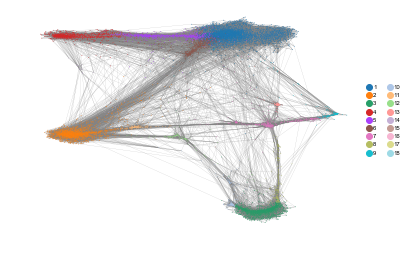

In [11]:
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.draw_graph(adata, color='Cluster', size=2, legend_fontsize=6, frameon=False, edges=True, title="")